# Comparison of arrival direction and joint models

In order to verify the model is working, we fit simulations made under the assumptions of the model. We also compare the differences between a model for only the UHECR arrival directions and one for both the UHECR arrival directions and energies.
<br>
<br>
*This code is used to produce the data shown in Figures 6, 7 and 8 (left panel) in Capel & Mortlock (2019).*  
*See the separate notebook in this directory for the actual plotting of figures.*

In [1]:
import numpy as np
import os
import h5py
from matplotlib import pyplot as plt
from pandas import DataFrame

from fancy import Data, Model, Analysis
from fancy.interfaces.stan import get_simulation_input

In [2]:
'''Setting up'''

# Define location of Stan files
stan_path = '../../stan/'

# Define file containing source catalogue information
source_file = '../../data/sourcedata.h5'

# make output directory if it doesnt exist
if not os.path.isdir("output"):
    os.mkdir("output")

# source_types = ["SBG_23", "2FHL_250Mpc", "swift_BAT_213"]
source_types = ["SBG_23"]

# detector_types = ["TA", "PAO"]
detector_type = "TA"

# set random seed
random_seed = 19990308

# flag to control showing plots or not
show_plot = True

# exposure factor
# exp_factors = [1., 5., 10., 100.]
exp_factors = [1., 5.]


In [3]:
'''set detector and detector properties'''
if detector_type == "TA":
    from fancy.detector.TA2015 import detector_properties, alpha_T, M, Eth
elif detector_type == "PAO":
    from fancy.detector.auger2014 import detector_properties, alpha_T, M, Eth
else:
    raise Exception("Undefined detector type!")


In [4]:
# store original total exposure and area to restore per iteration
alpha_T_0 = detector_properties["alpha_T"]
A_0 = detector_properties["A"]

In [5]:
'''Create joint simulated dataset'''

# Define a Stan simulation to run
sim_name = stan_path + 'joint_model_sim.stan' # simulate all processes

# Define simulation using Model object and compile Stan code if necessary
simulation = Model(sim_filename = sim_name, include_paths = stan_path)
simulation.compile(reset=False)


for source_type in source_types:
    for exp_factor in exp_factors:
        print("Current Source: {0}".format(source_type))
        print("Current Exposure Factor: {0}".format(exp_factor))
        # define separate files
        table_file = 'output/tables_{0}_{2}_epsx{1:.0f}.h5'.format(source_type, exp_factor, detector_type)
        sim_output_file = 'output/joint_model_simulation_{0}_{2}_epsx{1:.0f}.h5'.format(source_type, exp_factor, detector_type)


        # configure exposure factor
        alpha_T *= exp_factor

        # need to modify area since it also depends on alpha_T
        # A = alpha_T / (M * deltat)
        detector_properties["alpha_T"] *= exp_factor
        detector_properties["A"] *= exp_factor

        # check current exposure
        print("Checking if exposure is correct: ", detector_properties["alpha_T"] / exp_factor == alpha_T_0)

        # Define a source catalogue and detector exposure
        # In the paper we use the SBG catalogue
        data = Data()
        data.add_source(source_file, source_type)
        data.add_detector(detector_properties)

        # Plot the sources in Galactic coordinates
        # if show_plot:
        #     data.show();

        # Define associated fraction
        f = 0.5

        # Simulation input
        B = 20 # nG
        alpha = 3.0
        Eth_sim = 20 # EeV

        # number of simulated inputs
        # changes the background flux linearly
        # should choose Nsim such that FT is the same for
        # each observatory
        # this ensures that L, F0 are the same
        # 
        # for PAO, we saw that FT = 0.3601
        FT_PAO = 0.3601   # total flux using PAO data with Nsim = 2500
        Nsim_expected = FT_PAO / (M / alpha_T)
        Nsim = int(np.round(Nsim_expected))

        # check value for Nsim
        print("Simulated events: {0}".format(Nsim))


        # L in yr^-1, F in km^-2 yr^-1
        L, F0 = get_simulation_input(Nsim, f, data.source.distance, M, alpha_T)

        # To scale between definition of flux in simulations and fits
        flux_scale = (Eth / Eth_sim)**(1 - alpha)

        simulation.input(B = B, L = L, F0 = F0,
                    alpha = alpha, Eth = Eth)

        # check luminosity and isotropic flux values
        # L ~ O(10^39), F0 ~ 0.18
        # same luminosity so only need to check one value
        print("Simulated Luminosity: {0:.3e}".format(L[0]))
        print("Simulated isotropic flux: {0:.3f}".format(F0))


        # What is happening 
        summary = b'Simulation using the joint model and SBG catalogue' # must be a byte str
        # summary = b'Simulation using the joint model and Swift-BAT catalogue' # must be a byte str
            
        # Define an Analysis object to bring together Data and Model objects
        sim_analysis = Analysis(data, simulation, analysis_type = 'joint', 
                            filename = sim_output_file, summary = summary)

        print("Building tables...")

        # Build pre-computed values for the simulation as you go
        # So that you can try out different parameters
        sim_analysis.build_tables(sim_only = True)

        print("Running simulation...")
        # Run simulation
        sim_analysis.simulate(seed = random_seed, Eth_sim = Eth_sim)

        # Save to file 
        sim_analysis.save()

        # print resulting UHECR observed after propagation and Elosses
        print("Observed simulated UHECRs: {0}\n".format(len(sim_analysis.source_labels)))

        # reset exposure and area
        alpha_T = alpha_T_0
        detector_properties["alpha_T"] = alpha_T_0
        detector_properties["A"] = A_0

Using cached StanModel
Current Source: SBG_23
Current Exposure Factor: 1.0
Checking if exposure is correct:  True
Simulated events: 451
Simulated Luminosity: 3.351e+39
Simulated isotropic flux: 0.180
Building tables...


Precomputing exposure integral: 100%|██████████| 23/23 [00:01<00:00, 13.22it/s]



Running simulation...
Running Stan simulation...
Extracting output...
Simulating zenith angles...
Done!
Observed simulated UHECRs: 36

Current Source: SBG_23
Current Exposure Factor: 5.0
Checking if exposure is correct:  True
Simulated events: 2257
Simulated Luminosity: 3.354e+39
Simulated isotropic flux: 0.180
Building tables...


Precomputing exposure integral: 100%|██████████| 23/23 [00:01<00:00, 12.32it/s]



Running simulation...
Running Stan simulation...
Extracting output...
Simulating zenith angles...
Done!
Observed simulated UHECRs: 153



Current Source: SBG_23
Current Exposure Factor: 1.0
Using cached StanModel


Current Source: SBG_23
Current Exposure Factor: 5.0
Using cached StanModel


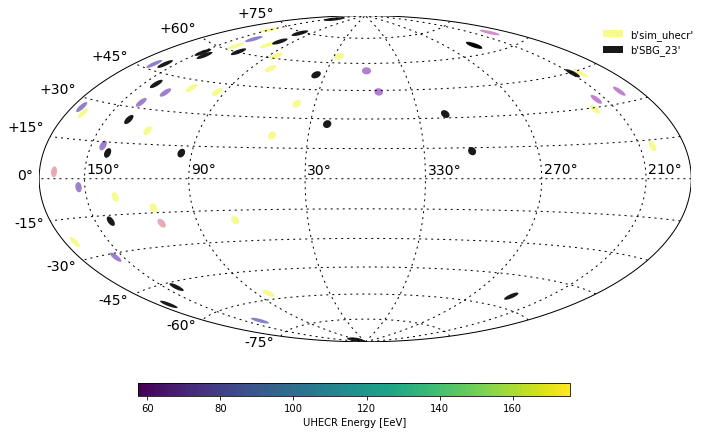

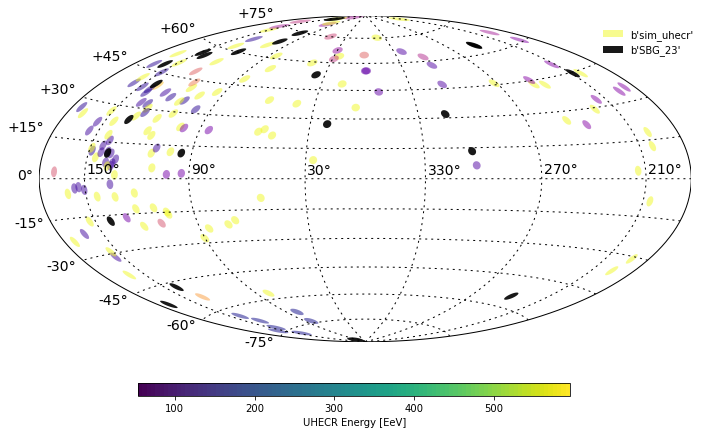

In [7]:
'''Fit using arrival direction model'''
for source_type in source_types:
    for exp_factor in exp_factors:
        print("Current Source: {0}".format(source_type))
        print("Current Exposure Factor: {0}".format(exp_factor))
        # define separate files
        table_file = 'output/tables_{0}_{2}_epsx{1:.0f}.h5'.format(source_type, exp_factor, detector_type)
        sim_output_file = 'output/joint_model_simulation_{0}_{2}_epsx{1:.0f}.h5'.format(source_type, exp_factor, detector_type)
        arrival_output_file = 'output/arrival_direction_fit_{0}_{2}_epsx{1:.0f}.h5'.format(source_type, exp_factor, detector_type)

        # Define data from simulation
        data = Data()
        data.from_file(sim_output_file)

        if show_plot:
            data.show()

        # Arrival direction model
        model_name = stan_path + 'arrival_direction_model.stan'

        # Compile
        model = Model(model_filename = model_name, include_paths = stan_path)
        model.compile(reset=False)

        # Define threshold energy in EeV
        model.input(Eth = Eth)

        # What is happening 
        summary = b'Fit of the arrival direction model to the joint simulation' 
            
        # Define an Analysis object to bring together Data and Model objects
        analysis = Analysis(data, model, analysis_type = 'joint', 
                            filename = arrival_output_file, summary = summary)

        # # Define location of pre-computed values used in fits 
        # # (see relevant notebook for how to make these files) 
        # # Each catalogue has a file of pre-computed values
        analysis.use_tables(table_file)

        # Fit the Stan model
        fit = analysis.fit_model(chains = 4, iterations = 2000, seed = random_seed, warmup=None)

        # Save to analysis file
        analysis.save()


In [9]:
'''Fit using joint model'''
for source_type in source_types:
    for exp_factor in exp_factors:
        print("Current Source: {0}".format(source_type))
        print("Current Exposure Factor: {0}".format(exp_factor))
        # define separate files
        table_file = 'output/tables_{0}_{2}_epsx{1:.0f}.h5'.format(source_type, exp_factor, detector_type)
        sim_output_file = 'output/joint_model_simulation_{0}_{2}_epsx{1:.0f}.h5'.format(source_type, exp_factor, detector_type)
        joint_output_file = 'output/joint_fit_{0}_{2}_epsx{1:.0f}.h5'.format(source_type, exp_factor, detector_type)

        # Define data from simulation
        data = Data()
        data.from_file(sim_output_file)

        # create Model and compile 
        model_name = stan_path + 'joint_model.stan'
        model = Model(model_filename = model_name, include_paths = stan_path)
        model.compile(reset=False)
        model.input(Eth = Eth)

        # create Analysis object
        summary = b'Fit of the joint model to the joint simulation' 
        analysis = Analysis(data, model, analysis_type = 'joint', 
                            filename = joint_output_file, summary = summary)
        analysis.use_tables(table_file)

        # Fit the Stan model
        fit = analysis.fit_model(chains = 4, iterations = 2000, seed = random_seed, warmup=None)

        # Save to analysis file
        analysis.save()


Current Source: SBG_23
Current Exposure Factor: 1.0
Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Current Source: SBG_23
Current Exposure Factor: 5.0
Using cached StanModel


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
